In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import functools
from datetime import datetime
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
!gdown "https://drive.google.com/uc?id=1qB32WBARlZe3VIVEPi0Ontgry-_AyBJe"
!gdown "https://drive.google.com/uc?id=1KTDgNMLQaIV2529h4xOcRqMGURFnoVQs"


Downloading...
From: https://drive.google.com/uc?id=1qB32WBARlZe3VIVEPi0Ontgry-_AyBJe
To: /content/train.csv
100% 31.3M/31.3M [00:00<00:00, 76.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KTDgNMLQaIV2529h4xOcRqMGURFnoVQs
To: /content/test.csv
100% 79.6k/79.6k [00:00<00:00, 37.8MB/s]


In [3]:
train_pd = pd.read_csv('train.csv', parse_dates=["time"])
test_pd = pd.read_csv('test.csv', parse_dates=["time"])
train_pd.dropna(inplace = True)
test_pd.dropna(inplace = True)

In [4]:
train_pv = train_pd.pivot(index=['time'], columns=['x', 'y', 'direction'], values= 'congestion')
train_pv

x                     0                                      ...   2          \
y                     0           1               2          ...   2           
direction            EB  NB  SB  EB  NB  SB  WB  EB  NB  SB  ...  SB  SE  SW   
time                                                         ...               
1991-04-01 00:00:00  70  49  24  18  60  58  26  31  49  46  ...  36  51  47   
1991-04-01 00:20:00  70  49  24  26  64  55  57  41  40  46  ...  10  51  50   
1991-04-01 00:40:00  70  49  24  31  51  57  91  42  41  35  ...  32  51  49   
1991-04-01 01:00:00  70  49  24  36  51  46  49  39  44  58  ...  60  51  49   
1991-04-01 01:20:00  70  49  24  29  53  83  62  36  46  46  ...  43  51  49   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..   
1991-09-30 10:20:00  43  29  60  23  63  61  42  47  51  56  ...  66  20  50   
1991-09-30 10:40:00  47  28  35  24  62  63  32  44  57  65  ...  60  21  49   
1991-09-30 11:00:00  40  31  53  22  65  58  38  44  60  62  ...  58  27  53   
1991-09-30 11:20:00  52  36  59  35  67  54  26  44  59  57  ...  52  20  53   
1991-09-30 11:40:00  70  40  51  24  65  52  42  43  62  77  ...  64  40  51   

x                                                
y                         3                      
direction            WB  EB  NB  NE  SB  SW  WB  
time                                             
1991-04-01 00:00:00  51  39  64  30  70  29  26  
1991-04-01 00:20:00  58  33  67  30  80  29  57  
1991-04-01 00:40:00  63  33  64  30  79  29  48  
1991-04-01 01:00:00  52  33  33  30  77  29  44  
1991-04-01 01:20:00  50  33  50  30  79  29  44  
...                  ..  ..  ..  ..  ..  ..  ..  
1991-09-30 10:20:00  70  90  53  29  68  22  49  
1991-09-30 10:40:00  68  45  52  25  70  20  47  
1991-09-30 11:00:00  68  44  58  29  69  19  37  
1991-09-30 11:20:00  67  57  59  22  69  22  53  
1991-09-30 11:40:00  71  48  54  28  68  17  24  

[13059 rows x 65 columns]

In [5]:
full_data = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])
full_data.index = full_data['time']
full_data.columns = pd.MultiIndex.from_product([full_data.columns, [''],['']])

In [6]:
full_train_pv = pd.merge(train_pv,full_data,how='outer', left_index=True, right_index=True)
full_train_pv.drop('time',axis=1,inplace=True)

In [7]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed = imp_mean.fit_transform(full_train_pv)
imp_train = pd.DataFrame(imputed,columns=full_train_pv.columns,index=full_train_pv.index).astype(int)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [8]:
imp_train['time'] = imp_train.index
imp_train['day'] = imp_train['time'].dt.dayofweek
# train_pd['date'] = train_pd['time'].dt.date
# train_pd['day_month'] = train_pd['time'].dt.strftime('%d').astype('int')
imp_train['weekend'] = (imp_train['day'] > 4).astype('uint8')
imp_train['hour'] = imp_train['time'].dt.hour
imp_train['hour_part'] = imp_train['time'].dt.minute
imp_train['hour_part'] = imp_train['hour_part'].map({0:0, 20: 1, 40: 2})
imp_train['month'] = imp_train['time'].dt.month



month = pd.get_dummies(imp_train['month'], prefix='month')
hour_part = pd.get_dummies(imp_train['hour_part'], prefix='hour_part')
day = pd.get_dummies(imp_train['day'], prefix='day')
hour = pd.get_dummies(imp_train['hour'], prefix='hour')
pds = [month, hour_part, day, hour, imp_train[['weekend']]]
features = functools.reduce(lambda a, b: pd.concat([a, b], axis=1), pds)

imp_train = imp_train.drop(['month'], axis=1)
imp_train = imp_train.drop(['hour_part'], axis=1)
imp_train = imp_train.drop(['day'], axis=1)
imp_train = imp_train.drop(['hour'], axis=1)
imp_train = imp_train.drop(['time'], axis=1)
imp_train = imp_train.drop(['weekend'], axis=1)

# imp_train = pd.concat([imp_train, month], axis=1)
# imp_train = pd.concat([imp_train, hour_part], axis=1)
# imp_train = pd.concat([imp_train, day], axis=1)
# imp_train = pd.concat([imp_train, hour], axis=1)

In [ ]:
imp_train

x                     0                                      ...   2          \
y                     0           1               2          ...   2           
direction            EB  NB  SB  EB  NB  SB  WB  EB  NB  SB  ...  SB  SE  SW   
time                                                         ...               
1991-04-01 00:00:00  70  49  24  18  60  58  26  31  49  46  ...  36  51  47   
1991-04-01 00:20:00  70  49  24  26  64  55  57  41  40  46  ...  10  51  50   
1991-04-01 00:40:00  70  49  24  31  51  57  91  42  41  35  ...  32  51  49   
1991-04-01 01:00:00  70  49  24  36  51  46  49  39  44  58  ...  60  51  49   
1991-04-01 01:20:00  70  49  24  29  53  83  62  36  46  46  ...  43  51  49   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..   
1991-09-30 10:20:00  43  29  60  23  63  61  42  47  51  56  ...  66  20  50   
1991-09-30 10:40:00  47  28  35  24  62  63  32  44  57  65  ...  60  21  49   
1991-09-30 11:00:00  40  31  53  22  65  58  38  44  60  62  ...  58  27  53   
1991-09-30 11:20:00  52  36  59  35  67  54  26  44  59  57  ...  52  20  53   
1991-09-30 11:40:00  70  40  51  24  65  52  42  43  62  77  ...  64  40  51   

x                                                
y                         3                      
direction            WB  EB  NB  NE  SB  SW  WB  
time                                             
1991-04-01 00:00:00  51  39  64  30  70  29  26  
1991-04-01 00:20:00  58  33  67  30  80  29  57  
1991-04-01 00:40:00  63  33  64  30  79  29  48  
1991-04-01 01:00:00  52  33  33  30  77  29  44  
1991-04-01 01:20:00  50  33  50  30  79  29  44  
...                  ..  ..  ..  ..  ..  ..  ..  
1991-09-30 10:20:00  70  90  53  29  68  22  49  
1991-09-30 10:40:00  68  45  52  25  70  20  47  
1991-09-30 11:00:00  68  44  58  29  69  19  37  
1991-09-30 11:20:00  67  57  59  22  69  22  53  
1991-09-30 11:40:00  71  48  54  28  68  17  24  

[13140 rows x 65 columns]

In [9]:
train_test_split = datetime.strptime('1991-09-23 12:00:00', '%Y-%m-%d %H:%M:%S')
train_features = features.loc[features.index < train_test_split]
val_features = features.loc[features.index >= train_test_split]

train_targets = imp_train.loc[imp_train.index < train_test_split]
val_targets = imp_train.loc[imp_train.index >= train_test_split]

In [10]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(150, kernel_initializer='normal',input_dim = features.shape[1], activation='relu'))
# NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.2))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dropout(0.2))

# The Output Layer :
NN_model.add(Dense(65, kernel_initializer='normal',activation='sigmoid'))

# Compile the network :
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
NN_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               6300      
                                                                 
 dense_1 (Dense)             (None, 512)               77312     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 65)                16705     
                                                                 
Total params: 231,645
Trainable params: 231,645
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = NN_model.fit(train_features.values, train_targets.values/100, epochs=60, batch_size=200, shuffle=True)

Epoch 1/60
64/64 [==============================] - 2s 13ms/step - loss: 0.0879 - mean_absolute_error: 0.0879
Epoch 2/60
64/64 [==============================] - 1s 18ms/step - loss: 0.0686 - mean_absolute_error: 0.0686
Epoch 3/60
64/64 [==============================] - 1s 21ms/step - loss: 0.0654 - mean_absolute_error: 0.0654
Epoch 4/60
64/64 [==============================] - 2s 25ms/step - loss: 0.0641 - mean_absolute_error: 0.0641
Epoch 5/60
64/64 [==============================] - 1s 22ms/step - loss: 0.0634 - mean_absolute_error: 0.0634
Epoch 6/60
64/64 [==============================] - 1s 14ms/step - loss: 0.0630 - mean_absolute_error: 0.0630
Epoch 7/60
64/64 [==============================] - 1s 13ms/step - loss: 0.0627 - mean_absolute_error: 0.0627
Epoch 8/60
64/64 [==============================] - 1s 13ms/step - loss: 0.0624 - mean_absolute_error: 0.0624
Epoch 9/60
64/64 [==============================] - 1s 13ms/step - loss: 0.0622 - mean_absolute_error: 0.0622
Epoch 10/6

In [12]:
from sklearn.metrics import mean_absolute_error
pred = NN_model.predict(val_features.values)
mean_absolute_error(val_targets.values,np.round(pred*100))

6.286446886446887

In [22]:
mean_absolute_error(val_targets.iloc[:36,:].values.reshape(36*65,),np.round(pred*100)[:36,:].reshape(36*65,))

5.186752136752137

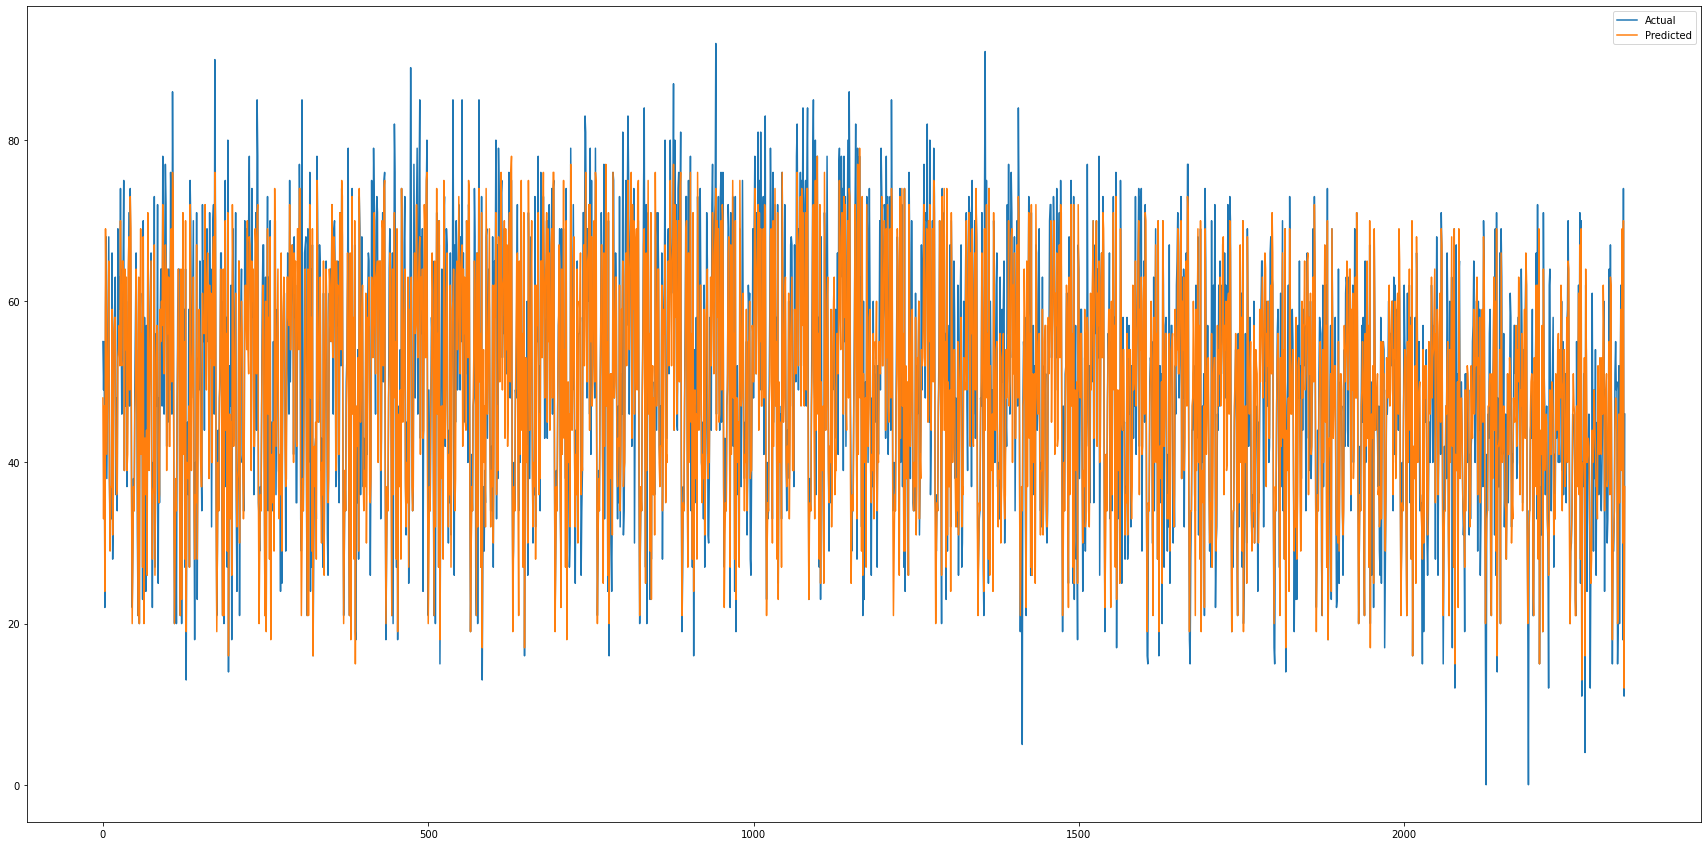

In [24]:
plt.figure(figsize=(30,15))
plt.plot(val_targets.iloc[:36,:].values.reshape(36*65,), label='Actual')
plt.plot(np.round(pred*100)[:36,:].reshape(36*65,), label='Predicted')
plt.legend()
plt.show()

In [ ]:
history = NN_model.fit(features.values, imp_train.values/100, epochs=60, batch_size=200, shuffle=True)

Epoch 1/60
66/66 [==============================] - 2s 12ms/step - loss: 0.0867 - mean_absolute_error: 0.0867
Epoch 2/60
66/66 [==============================] - 1s 12ms/step - loss: 0.0682 - mean_absolute_error: 0.0682
Epoch 3/60
66/66 [==============================] - 1s 12ms/step - loss: 0.0654 - mean_absolute_error: 0.0654
Epoch 4/60
66/66 [==============================] - 1s 12ms/step - loss: 0.0641 - mean_absolute_error: 0.0641
Epoch 5/60
66/66 [==============================] - 1s 12ms/step - loss: 0.0634 - mean_absolute_error: 0.0634
Epoch 6/60
66/66 [==============================] - 1s 12ms/step - loss: 0.0630 - mean_absolute_error: 0.0630
Epoch 7/60
66/66 [==============================] - 1s 12ms/step - loss: 0.0626 - mean_absolute_error: 0.0626
Epoch 8/60
66/66 [==============================] - 1s 13ms/step - loss: 0.0624 - mean_absolute_error: 0.0624
Epoch 9/60
66/66 [==============================] - 1s 12ms/step - loss: 0.0620 - mean_absolute_error: 0.0620
Epoch 10/6

In [ ]:
test_pd = test_pd.pivot(index=['time'], columns=['x', 'y', 'direction'])
test_pd['time'] = test_pd.index
test_pd['day'] = test_pd['time'].dt.dayofweek
# train_pd['date'] = train_pd['time'].dt.date
# train_pd['day_month'] = train_pd['time'].dt.strftime('%d').astype('int')
test_pd['weekend'] = (test_pd['day'] > 4).astype('uint8')
test_pd['hour'] = test_pd['time'].dt.hour
test_pd['hour_part'] = test_pd['time'].dt.minute
test_pd['hour_part'] = test_pd['hour_part'].map({0:0, 20: 1, 40: 2})
test_pd['month'] = test_pd['time'].dt.month

month = pd.get_dummies(test_pd['month'], prefix='month')
hour_part = pd.get_dummies(test_pd['hour_part'], prefix='hour_part')
day = pd.get_dummies(test_pd['day'], prefix='day')
hour = pd.get_dummies(test_pd['hour'], prefix='hour')
pds = [month, hour_part, day, hour, test_pd[['weekend']]]
test_features = functools.reduce(lambda a, b: pd.concat([a, b], axis=1), pds)

# imp_train = imp_train.drop(['month'], axis=1)
# imp_train = imp_train.drop(['hour_part'], axis=1)
# imp_train = imp_train.drop(['day'], axis=1)
# imp_train = imp_train.drop(['hour'], axis=1)
# imp_train = imp_train.drop(['time'], axis=1)
# imp_train = imp_train.drop(['weekend'], axis=1)


In [ ]:
days = ['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
hours = ['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
         'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11']
months = ['month_4', 'month_5', 'month_6', 'month_7', 'month_8']
for month in reversed(months):
  test_features.insert(0, month, 0)
for d in reversed(days):
  test_features.insert(10, d, 0)
for h in reversed(hours):
  test_features.insert(16, h, 0)
test_features.columns

Index([              'month_4',               'month_5',
                     'month_6',               'month_7',
                     'month_8',               'month_9',
                 'hour_part_0',           'hour_part_1',
                 'hour_part_2',                 'day_0',
                       'day_1',                 'day_2',
                       'day_3',                 'day_4',
                       'day_5',                 'day_6',
                      'hour_0',                'hour_1',
                      'hour_2',                'hour_3',
                      'hour_4',                'hour_5',
                      'hour_6',                'hour_7',
                      'hour_8',                'hour_9',
                     'hour_10',               'hour_11',
                     'hour_12',               'hour_13',
                     'hour_14',               'hour_15',
                     'hour_16',               'hour_17',
                     'hour_18',

In [ ]:
test_features

,month_4,month_5,month_6,month_7,month_8,month_9,hour_part_0,hour_part_1,hour_part_2,day_0,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,"(weekend, , , )"
time,,,,,,,,,,,,,,,,,,,,,
1991-09-30 12:00:00,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 12:20:00,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 12:40:00,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 13:00:00,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 13:20:00,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 13:40:00,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 14:00:00,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 14:20:00,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1991-09-30 14:40:00,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pred = NN_model.predict(test_features.values)

In [ ]:
submission = pd.read_csv('submission.csv')

In [ ]:
submission['congestion'] = np.round(pred.reshape(36*65,)*100).astype(int)

In [ ]:
submission.to_csv('./submission1.csv', index=False)